# 注意力汇聚：Nadaraya-Watson 核回归

In [1]:
import torch
from torch import nn
import d2l_torch as d2l

生成一列 (x, y) pairs，如何通过 x 来预测 y

首先来定义 x 和 y 的关系，其中 为噪声项：

$y_i=2 \sin \left(x_i\right)+x_i^{0.8}+\epsilon$

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

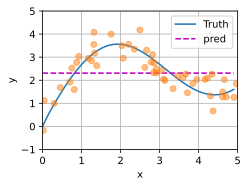

In [4]:
# 基于平均汇聚的输出
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

平均汇聚忽略了每个 x 对每个 y 产生的不均等的影响。

$f(x)=\sum_{i=1}^n \frac{K\left(x-x_i\right)}{\sum_{j=1}^n K\left(x-x_j\right)} y_i$

上述估计器被称为 Nadaraya-Watson 核回归。

摆脱特定的计算方法，我们可以写一个更通用的注意力汇聚公式：

$f(x)=\sum_{i=1}^n \alpha\left(x, x_i\right) y_i$

注意力就是对查询 x 和键 $x_i$ 的关系建模为注意力权重 (attention weight)。对任意一个查询 x，注意力权重 $\alpha\left(x, x_i\right)$ 都是一个有效的概率分布：它是非负的，且总和为 1.

我们将高斯核代入 Nadaraya-Watson 核回归。

$K(u)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{u^2}{2}\right)$.

带入得：

$\begin{aligned} f(x) & =\sum_{i=1}^n \alpha\left(x, x_i\right) y_i \\ & =\sum_{i=1}^n \frac{\exp \left(-\frac{1}{2}\left(x-x_i\right)^2\right)}{\sum_{j=1}^n \exp \left(-\frac{1}{2}\left(x-x_j\right)^2\right)} y_i \\ & =\sum_{i=1}^n \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_i\right)^2\right) y_i\end{aligned}$

也就是说，如果一个键 $x_j$ 越是接近给定的查询 $x$，那么分配给这个键对应值 $y_i$ 的注意力权重就会越大，也就获得了更多的注意力。值得注意的是，Nadaraya-Watson 核回归是一个非参数模型（即模型内部没有参数可供学习）。

In [5]:
x_test.repeat_interleave(n_train)

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9000, 4.9000, 4.9000])

In [6]:
# 查询
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
X_repeat

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])

In [7]:
# key
x_train

tensor([0.0180, 0.0421, 0.2981, 0.4535, 0.7000, 0.7518, 0.8145, 0.8739, 0.9281,
        1.1712, 1.2558, 1.3130, 1.3200, 1.3376, 1.3898, 1.7562, 2.0338, 2.0659,
        2.2063, 2.3559, 2.4947, 2.6229, 2.6636, 2.7844, 2.8197, 2.8484, 2.8550,
        2.9156, 2.9175, 3.0570, 3.1018, 3.1388, 3.3448, 3.4638, 3.6005, 3.6703,
        3.7130, 3.8515, 3.9549, 4.1635, 4.2249, 4.3051, 4.3475, 4.3700, 4.6135,
        4.6176, 4.6589, 4.7080, 4.9067, 4.9653])

In [8]:
# 广播
X_repeat - x_train, (X_repeat - x_train).shape

(tensor([[-0.0180, -0.0421, -0.2981,  ..., -4.7080, -4.9067, -4.9653],
         [ 0.0820,  0.0579, -0.1981,  ..., -4.6080, -4.8067, -4.8653],
         [ 0.1820,  0.1579, -0.0981,  ..., -4.5080, -4.7067, -4.7653],
         ...,
         [ 4.6820,  4.6579,  4.4019,  ..., -0.0080, -0.2067, -0.2653],
         [ 4.7820,  4.7579,  4.5019,  ...,  0.0920, -0.1067, -0.1653],
         [ 4.8820,  4.8579,  4.6019,  ...,  0.1920, -0.0067, -0.0653]]),
 torch.Size([50, 50]))

In [9]:
torch.zeros(2,2) - torch.tensor([1,2])

tensor([[-1., -2.],
        [-1., -2.]])

In [10]:
# 计算高斯核
-(X_repeat - x_train)**2 / 2

tensor([[-1.6243e-04, -8.8454e-04, -4.4446e-02,  ..., -1.1083e+01,
         -1.2038e+01, -1.2327e+01],
        [-3.3600e-03, -1.6785e-03, -1.9631e-02,  ..., -1.0617e+01,
         -1.1552e+01, -1.1836e+01],
        [-1.6558e-02, -1.2472e-02, -4.8163e-03,  ..., -1.0161e+01,
         -1.1076e+01, -1.1354e+01],
        ...,
        [-1.0960e+01, -1.0848e+01, -9.6882e+00,  ..., -3.1915e-05,
         -2.1356e-02, -3.5195e-02],
        [-1.1434e+01, -1.1319e+01, -1.0133e+01,  ..., -4.2330e-03,
         -5.6893e-03, -1.3664e-02],
        [-1.1917e+01, -1.1800e+01, -1.0589e+01,  ..., -1.8434e-02,
         -2.2248e-05, -2.1328e-03]])

In [11]:
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
attention_weights

tensor([[9.1848e-02, 9.1782e-02, 8.7870e-02,  ..., 1.4127e-06, 5.4354e-07,
         4.0694e-07],
        [8.4632e-02, 8.4774e-02, 8.3266e-02,  ..., 2.0806e-06, 8.1659e-07,
         6.1496e-07],
        [7.7674e-02, 7.7992e-02, 7.8592e-02,  ..., 3.0522e-06, 1.2220e-06,
         9.2565e-07],
        ...,
        [1.0195e-06, 1.1406e-06, 3.6385e-06,  ..., 5.8670e-02, 5.7432e-02,
         5.6643e-02],
        [6.7661e-07, 7.5881e-07, 2.4834e-06,  ..., 6.2240e-02, 6.2149e-02,
         6.1656e-02],
        [4.4716e-07, 5.0269e-07, 1.6879e-06,  ..., 6.5747e-02, 6.6968e-02,
         6.6827e-02]])

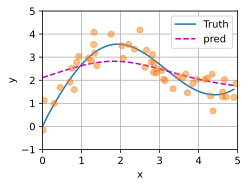

In [12]:
# softmax(K(u)V)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

我们还是可以很轻松地将可学习的参数集成到注意力汇聚中。

$\begin{aligned} f(x) & =\sum_{i=1}^n \alpha\left(x, x_i\right) y_i \\ & =\sum_{i=1}^n \frac{\exp \left(-\frac{1}{2}\left(\left(x-x_i\right) w\right)^2\right)}{\sum_{j=1}^n \exp \left(-\frac{1}{2}\left(\left(x-x_j\right) w\right)^2\right)} y_i \\ & =\sum_{i=1}^n \operatorname{softmax}\left(-\frac{1}{2}\left(\left(x-x_i\right) w\right)^2\right) y_i .\end{aligned}$

In [13]:
# 带参数的注意力汇聚

# 批量矩阵乘法
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y), torch.bmm(X, Y).shape

(tensor([[[4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.]]]),
 torch.Size([2, 1, 6]))

In [14]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [15]:
# 在第一个维度之后，插入一个新的维度
weights.shape, weights.unsqueeze(1).shape

(torch.Size([2, 10]), torch.Size([2, 1, 10]))

In [16]:
# 在最后一个维度，插入一个新的维度
values.shape, values.unsqueeze(-1).shape

(torch.Size([2, 10]), torch.Size([2, 10, 1]))

In [17]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # self.w 决定了核宽度，从而影响匹配度量的敏感度
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [18]:
# 训练
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [19]:
x_train.repeat((n_train, 1)).shape, y_train.repeat((n_train, 1)).shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [20]:
(1 - torch.eye(n_train)).type(torch.bool)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])

In [21]:
X_tile[(1 - torch.eye(n_train)).type(torch.bool)]

tensor([0.0421, 0.2981, 0.4535,  ..., 4.6589, 4.7080, 4.9067])

In [22]:
keys.shape, values.shape

(torch.Size([50, 49]), torch.Size([50, 49]))

In [23]:
X_tile[(1 - torch.eye(n_train)).type(torch.bool)]

tensor([0.0421, 0.2981, 0.4535,  ..., 4.6589, 4.7080, 4.9067])

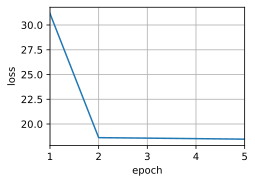

In [24]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

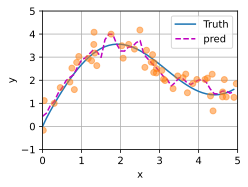

In [25]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
# keys = keys[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values = values[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

In [26]:
keys.shape, values.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

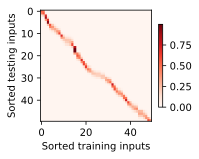

In [27]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [28]:
net.attention_weights.shape

torch.Size([50, 50])

In [29]:
net.attention_weights.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 50, 50])

参考：

- http://zh-v2.d2l.ai/chapter_attention-mechanisms/nadaraya-waston.html
- https://zhuanlan.zhihu.com/p/569527564